In [109]:
import sys

sys.path.append("../")

In [110]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [111]:
import os

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# import data.drawings.make_tasks as drawing_tasks
from src.analysis_utilities import SynthesisExperimentAnalyzer
from src.config_builder import ExperimentType

In [112]:
sns.set_theme(style="whitegrid", font_scale=1.25, rc={'figure.figsize':(12, 8)})

In [113]:
%config InlineBackend.figure_format = 'retina'

In [114]:
EXPERIMENT_NAME = "runs_multi"

COMPUTE_LIKELIHOODS = True

FIGURES_DIR = os.path.join("figures", EXPERIMENT_NAME)
os.makedirs(FIGURES_DIR, exist_ok=True)

In [227]:
analyzer = SynthesisExperimentAnalyzer(
    experiment_name=EXPERIMENT_NAME,
    experiment_types=["baseline_dreamcoder", "gpt_solver", "gpt_solver_stitch_namer", "gpt_solver_stitch_namer_hybrid_dsl", "gpt_solver_stitch_namer_search"],
    allow_incomplete_results=True,
    compute_likelihoods=COMPUTE_LIKELIHOODS,
    batch_size = 96,
    seeds = [111, 222, 333],
)

Experiment directory: ../experiments_iterative/outputs/runs_multi
Available domains: ['re2', 'clevr', 'logo']


# Tasks solved vs. LAPS iteration

In [228]:
df_results = analyzer.get_synthesis_summary()
df_results

domain                 experiment_type  seed  iteration  split  n_solved  \
0    clevr             baseline_dreamcoder   111          0   test        43   
1    clevr             baseline_dreamcoder   111          0  train        41   
2    clevr             baseline_dreamcoder   111          1  train        97   
3    clevr             baseline_dreamcoder   111          2  train       127   
4    clevr             baseline_dreamcoder   111          3   test        86   
..     ...                             ...   ...        ...    ...       ...   
671    re2  gpt_solver_stitch_namer_search   333         12  train       327   
672    re2  gpt_solver_stitch_namer_search   333         13  train       328   
673    re2  gpt_solver_stitch_namer_search   333         14  train       332   
674    re2  gpt_solver_stitch_namer_search   333         15   test       334   
675    re2  gpt_solver_stitch_namer_search   333         15  train       333   

     percent_solved  
0          0.417476  
1          0.214660  
2          0.507853  
3          0.664921  
4          0.834951  
..              ...  
671        0.665988  
672        0.668024  
673        0.676171  
674        0.668000  
675        0.678208  

[676 rows x 7 columns]

In [229]:
analyzer.format_dataframe_camera(df_results)

domain            Model  seed  iteration  split  n_solved  \
0    CLEVR       DreamCoder   111          0   test        43   
1    CLEVR       DreamCoder   111          0  train        41   
2    CLEVR       DreamCoder   111          1  train        97   
3    CLEVR       DreamCoder   111          2  train       127   
4    CLEVR       DreamCoder   111          3   test        86   
..     ...              ...   ...        ...    ...       ...   
671  REGEX  LILO (+ Search)   333         12  train       327   
672  REGEX  LILO (+ Search)   333         13  train       328   
673  REGEX  LILO (+ Search)   333         14  train       332   
674  REGEX  LILO (+ Search)   333         15   test       334   
675  REGEX  LILO (+ Search)   333         15  train       333   

     Tasks solved (%)  
0           41.747573  
1           21.465969  
2           50.785340  
3           66.492147  
4           83.495146  
..                ...  
671         66.598778  
672         66.802444  
673         67.617108  
674         66.800000  
675         67.820774  

[676 rows x 7 columns]

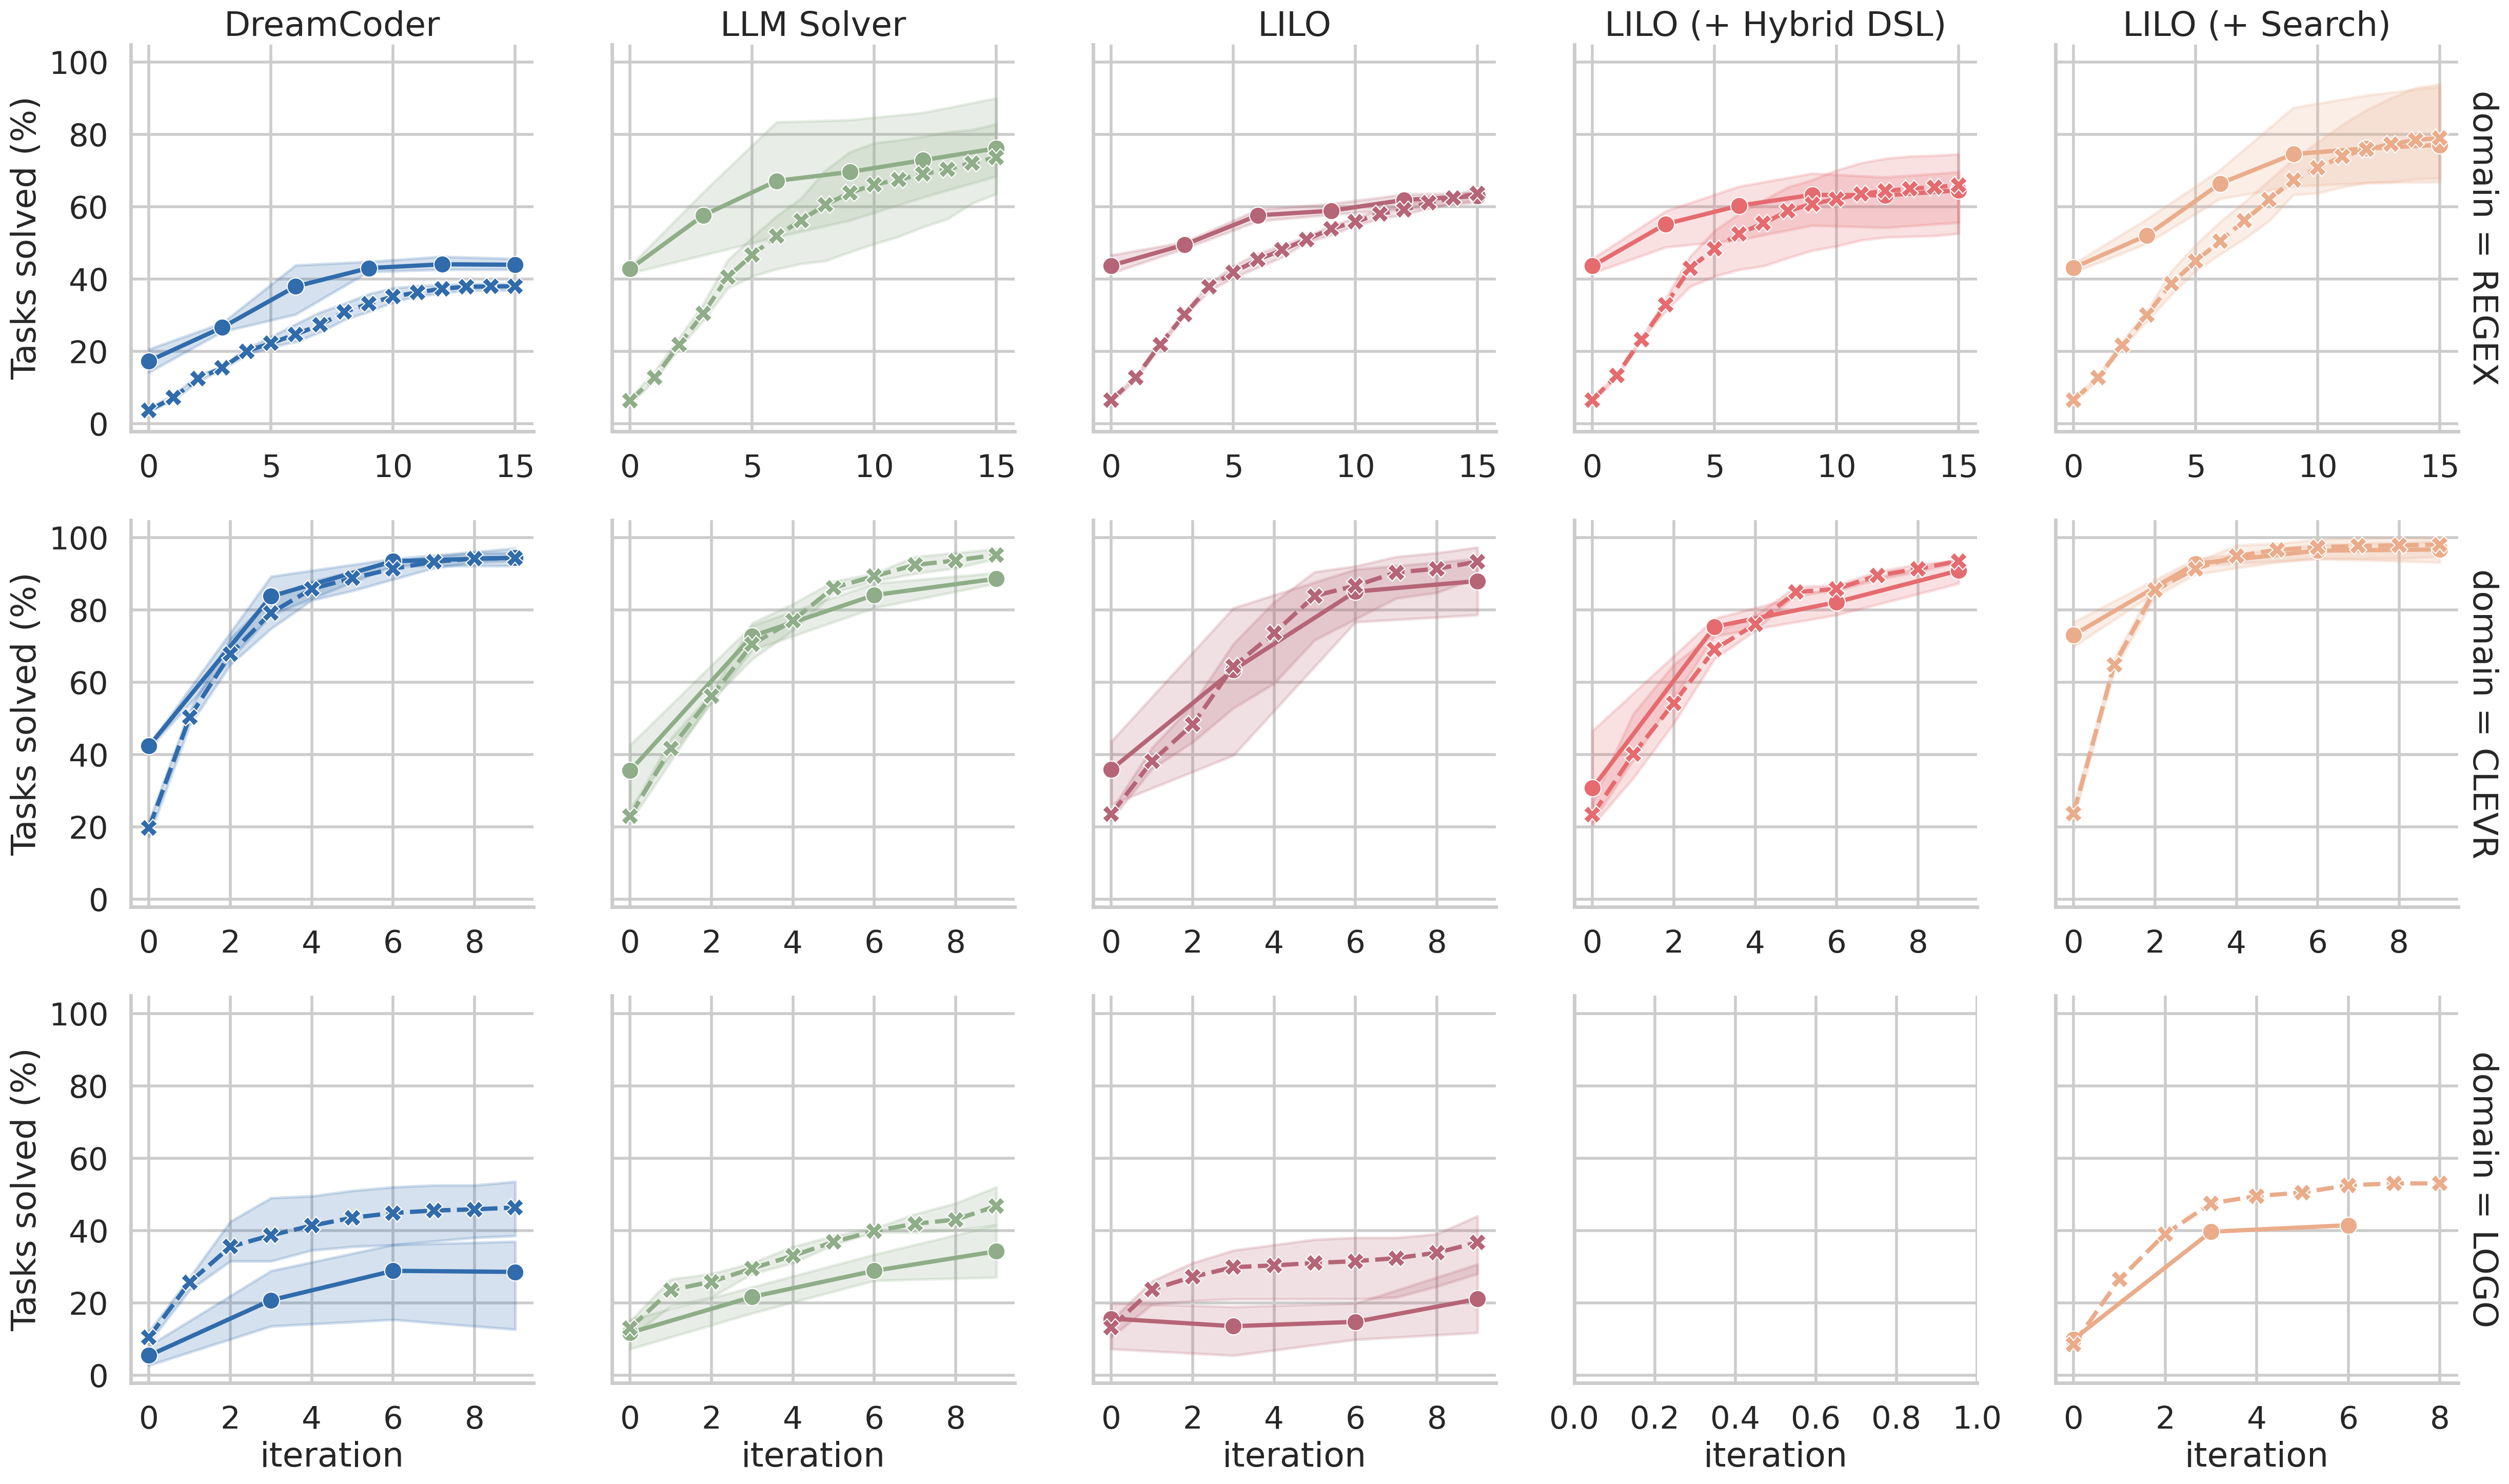

In [230]:
with sns.plotting_context("poster", font_scale=1):
    g = sns.relplot(
        data=analyzer.format_dataframe_camera(df_results),
        kind="line",
        row="domain",
        col=analyzer.COL_NAMES_CAMERA["experiment_type"],
        x="iteration", 
        y=analyzer.COL_NAMES_CAMERA["percent_solved"],
        hue=analyzer.COL_NAMES_CAMERA["experiment_type"],
        style="split",
        markers=True,
        # errorbar="se",
        # col_order=["train", "test"],
        row_order = list(analyzer.DOMAIN_NAMES_CAMERA.values()),
        facet_kws={'sharex': False, 'sharey': True, 'margin_titles': True},
        palette=analyzer.EXPERIMENT_TYPES_PALETTE,
        legend=False,
    )
    for subplot in g.axes[0]:
        subplot.set_title(subplot.title.get_text().split(" = ")[-1])
        
    # sns.move_legend(g, "lower center")
        
    # plt.savefig(os.path.join(FIGURES_DIR, "main_results.pdf"), dpi=300, bbox_inches="tight")

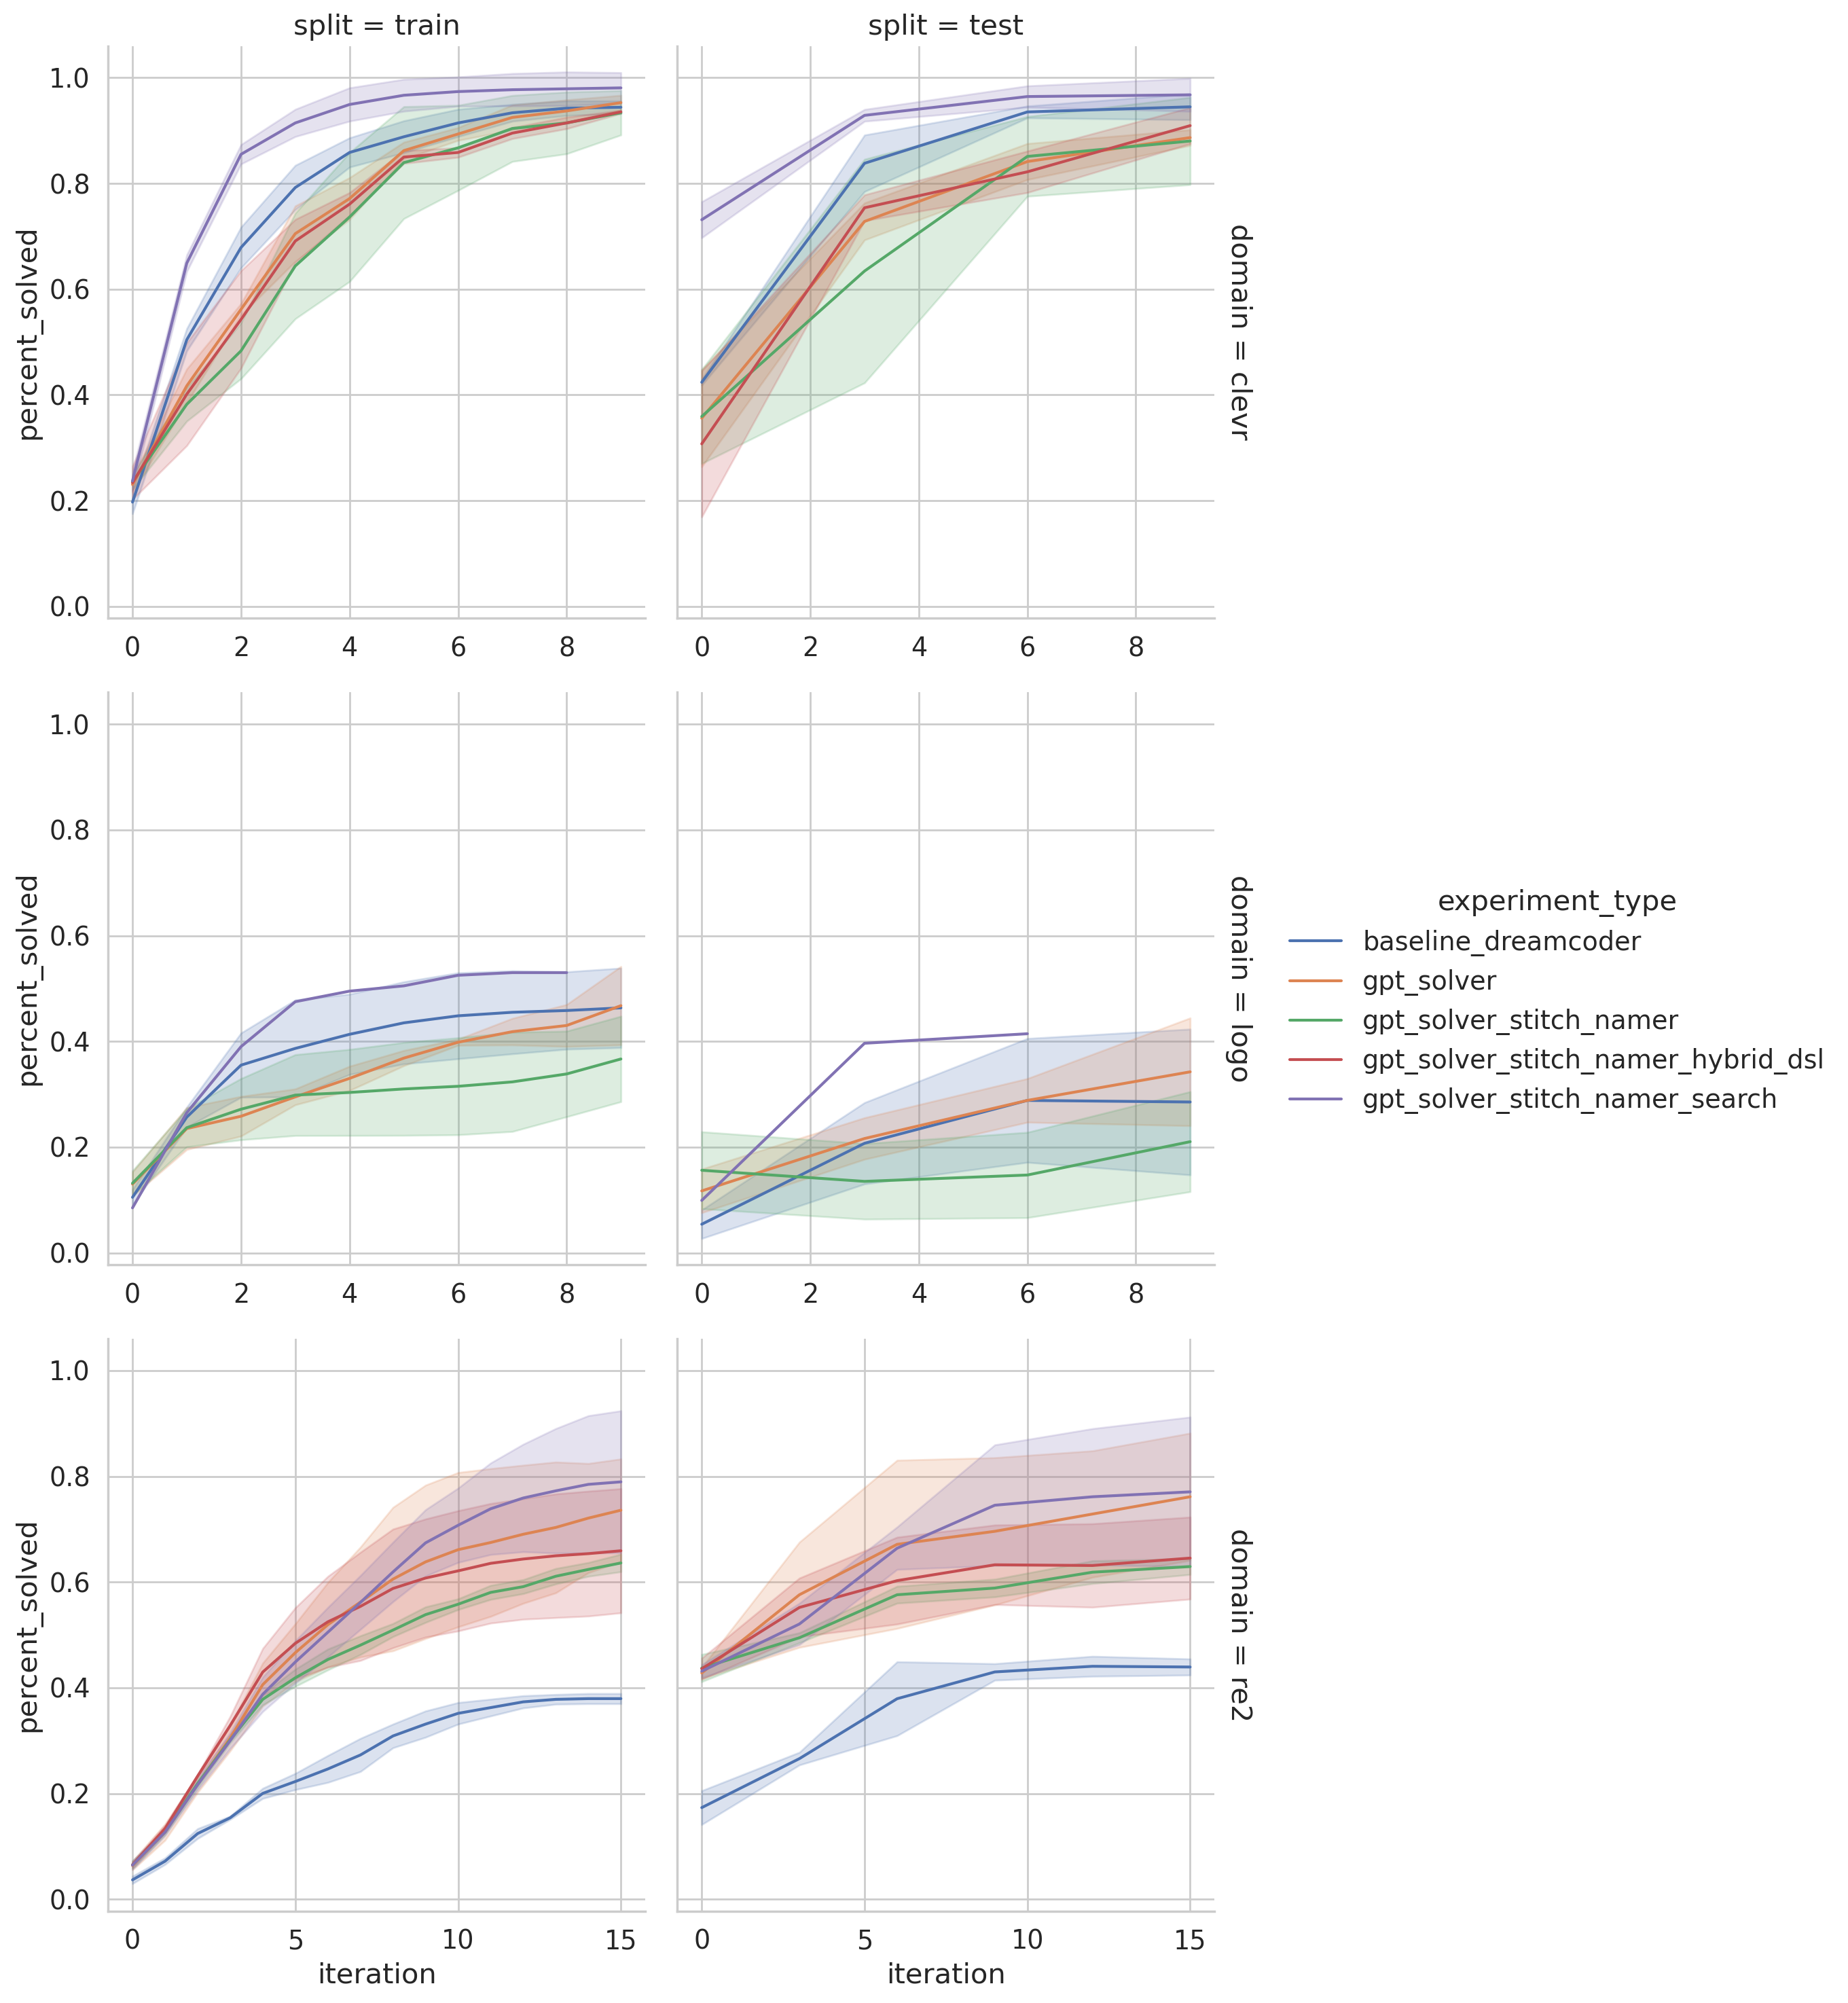

In [231]:
sns.relplot(
    data=df_results,
    kind="line",
    row="domain",
    col="split",
    x="iteration", 
    y="percent_solved", 
    hue="experiment_type",
    # style="seed",
    markers=True,
    errorbar="sd", # se
    col_order=["train", "test"],
    facet_kws={'sharex': False, 'sharey': True, 'margin_titles': True}
)
# plt.suptitle(f"{DOMAIN}", y=1.025)

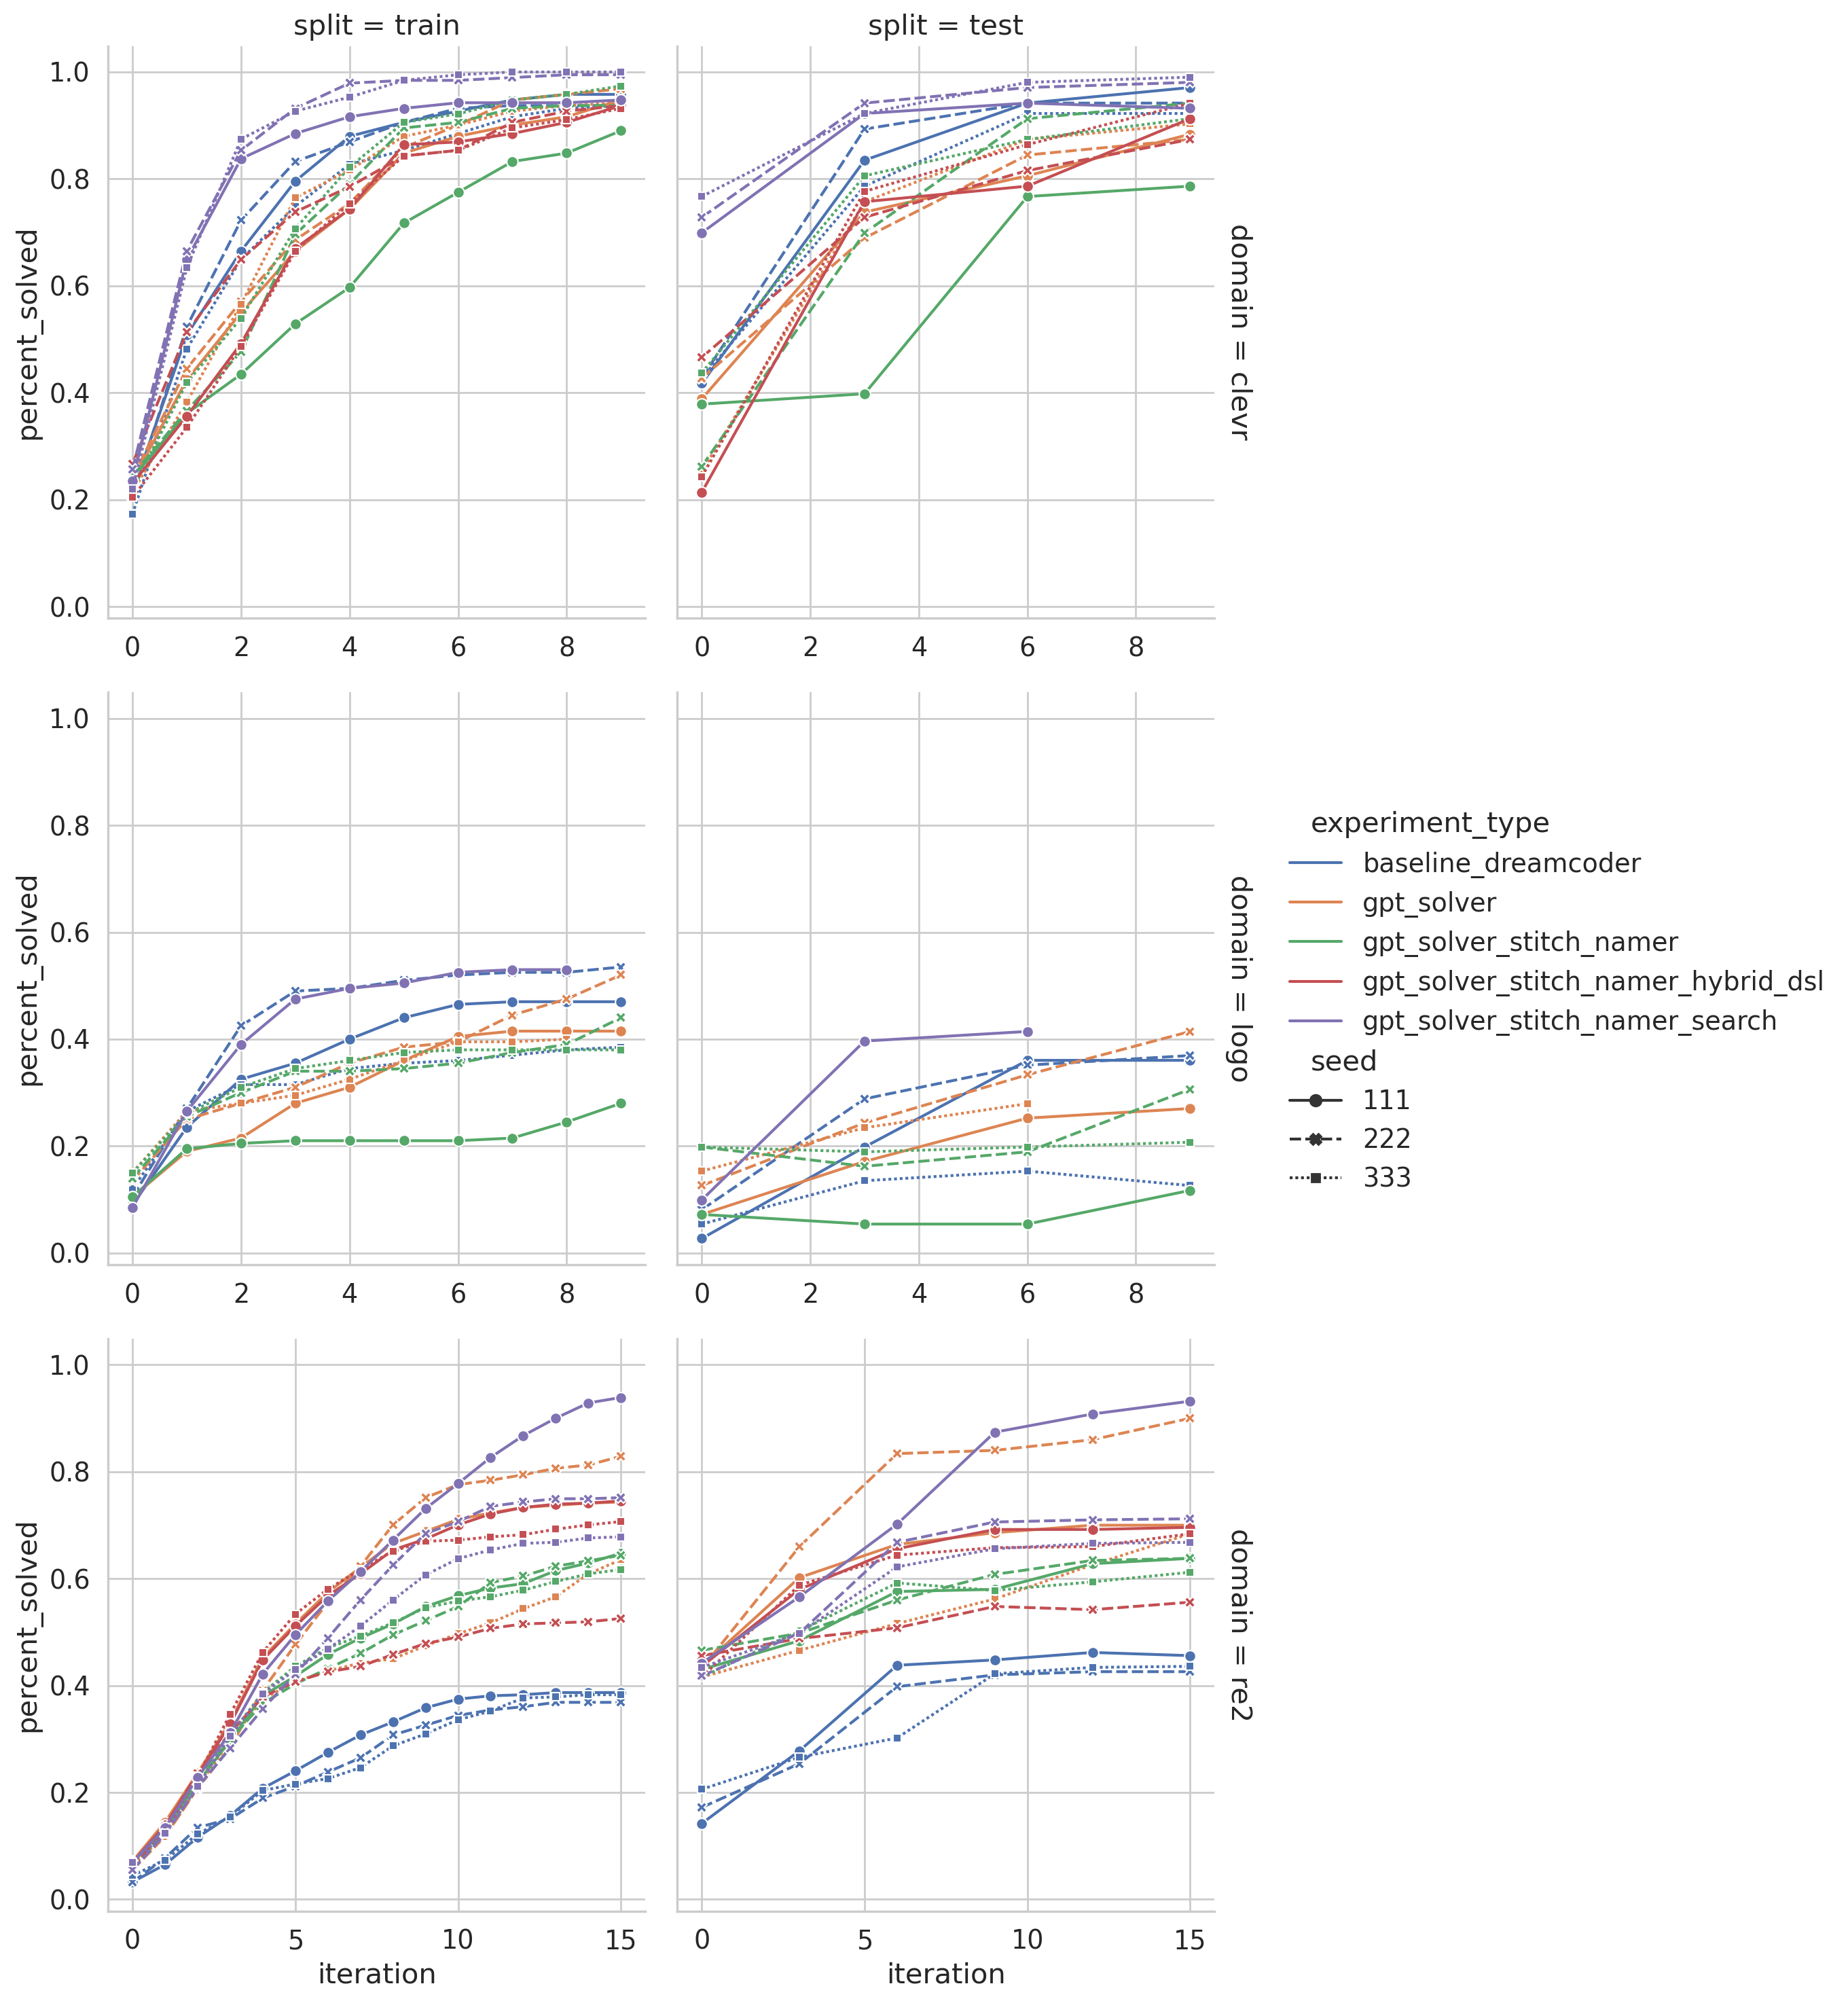

In [232]:
sns.relplot(
    data=df_results,
    kind="line",
    row="domain",
    col="split",
    x="iteration", 
    y="percent_solved", 
    hue="experiment_type",
    style="seed",
    markers=True,
    # errorbar="se",
    col_order=["train", "test"],
    facet_kws={'sharex': False, 'sharey': True, 'margin_titles': True}
)
# plt.suptitle(f"{DOMAIN}", y=1.025)

# Main results table

In [241]:
df_results_test = df_results.query("split == 'test'")
grouped = analyzer.format_dataframe_camera(df_results_test).groupby([
    "domain",
    analyzer.COL_NAMES_CAMERA["experiment_type"],
    "seed",
], as_index=False)

def _get_final_iteration(group):
    final_iteration = group["iteration"].max().item()
    return group[group["iteration"] == final_iteration]

df_results_test = grouped.apply(_get_final_iteration).reset_index(drop=True)
# df_results_test

In [242]:
df_metrics_test = df_results_test.groupby([
    "domain",
    analyzer.COL_NAMES_CAMERA["experiment_type"],
]) \
[[
    analyzer.COL_NAMES_CAMERA["percent_solved"]
]] \
.agg(["mean", "max", "std"])

# df_metrics_test

In [246]:
df_metrics_test_final.columns

MultiIndex([('CLEVR', 'Tasks solved (%)',  'max'),
            ('CLEVR', 'Tasks solved (%)', 'mean'),
            ('CLEVR', 'Tasks solved (%)',  'std'),
            ( 'LOGO', 'Tasks solved (%)',  'max'),
            ( 'LOGO', 'Tasks solved (%)', 'mean'),
            ( 'LOGO', 'Tasks solved (%)',  'std'),
            ('REGEX', 'Tasks solved (%)',  'max'),
            ('REGEX', 'Tasks solved (%)', 'mean'),
            ('REGEX', 'Tasks solved (%)',  'std')],
           )

In [252]:
# Reorder column levels
df_metrics_test_final = df_metrics_test.reset_index().pivot(index="Model", columns="domain").reorder_levels(order=[0, 2, 1], axis="columns")
df_metrics_test_final.columns.names = [None, None, None]
df_metrics_test_final = df_metrics_test_final.reindex(columns=pd.MultiIndex.from_tuples(sorted(df_metrics_test_final.columns)))
# df_metrics_test_final = df_metrics_test_final.droplevel(axis="columns", level=1)

# Reorder rows
experiment_types = [x for x in analyzer.EXPERIMENT_TYPES_CAMERA.values() if x in df_metrics_test_final.index]
df_metrics_test_final = df_metrics_test_final.reindex(experiment_types)

# Remove 'Model'
df_metrics_test_final.index.name = None

# Round numbers
df_metrics_test_final = df_metrics_test_final.round(2)

# Output to LaTeX
df_metrics_test_final.to_latex("main_results_table.tex")

df_metrics_test_final

Tasks solved (%)                                          \
                               CLEVR                LOGO               REGEX   
                                 max   mean   std    max   mean    std   max   
DreamCoder                     97.09  94.50  2.44  36.94  28.53  13.79  45.6   
LLM Solver                     90.29  88.67  1.48  41.44  32.13   8.07  90.0   
LILO                           94.17  88.03  8.26  30.63  21.02   9.46  63.8   
LILO (+ Hybrid DSL)            94.17  90.94  3.41    NaN    NaN    NaN  69.6   
LILO (+ Search)                99.03  96.76  3.12  41.44  41.44    NaN  93.2   

                                   
                                   
                      mean    std  
DreamCoder           43.93   1.53  
LLM Solver           76.13  12.04  
LILO                 62.93   1.50  
LILO (+ Hybrid DSL)  64.53   7.76  
LILO (+ Search)      77.07  14.14

# Runtime metrics

In [122]:
df_runtime = analyzer.get_runtime_metrics()
df_runtime.groupby(["domain", "experiment_type", "model_type", "model_fn", "task_split"]).time_elapsed.agg("mean")

Not found: ../experiments_iterative/outputs/runs_multi/domains/logo/gpt_solver/seed_333/gpt_solver_96/9/metrics.json


domain  experiment_type                     model_type           model_fn                      task_split
clevr   baseline_dreamcoder                 amortized_synthesis  infer_programs_for_tasks      test           627.410529
                                                                                               train          626.392419
                                                                 optimize_model_for_frontiers  train          639.112597
                                            grammar              infer_programs_for_tasks      train          602.131269
        gpt_solver                          llm_solver           infer_programs_for_tasks      test           754.704399
                                                                                               train          717.473114
        gpt_solver_stitch_namer             library_namer        generate_library_names        train           17.619742
                                            llm

In [123]:
df_infer_programs = df_runtime.query("model_fn == 'infer_programs_for_tasks'").query("model_type != 'grammar'")
df_infer_programs

curr_iteration           model_type                  model_fn  \
0                  0           llm_solver  infer_programs_for_tasks   
2                  0  amortized_synthesis  infer_programs_for_tasks   
3                  0  amortized_synthesis  infer_programs_for_tasks   
5                  1  amortized_synthesis  infer_programs_for_tasks   
7                  2  amortized_synthesis  infer_programs_for_tasks   
...              ...                  ...                       ...   
1262               6  amortized_synthesis  infer_programs_for_tasks   
1264               7           llm_solver  infer_programs_for_tasks   
1266               7  amortized_synthesis  infer_programs_for_tasks   
1268               8           llm_solver  infer_programs_for_tasks   
1270               8  amortized_synthesis  infer_programs_for_tasks   

     task_split                          time_start  \
0         train 2023-05-03 18:24:40.524954368+00:00   
2         train 2023-04-28 22:24:19.571785472+00:00   
3          test 2023-04-28 22:41:05.210528768+00:00   
5         train 2023-04-29 00:13:29.896112384+00:00   
7         train 2023-04-29 00:34:49.866311680+00:00   
...         ...                                 ...   
1262       test 2023-05-08 11:06:50.065977344+00:00   
1264      train 2023-05-08 11:39:46.030694656+00:00   
1266      train 2023-05-08 12:07:07.739521792+00:00   
1268      train 2023-05-08 12:38:51.239604224+00:00   
1270      train 2023-05-08 13:06:42.077441536+00:00   

                                time_end  time_elapsed domain  \
0    2023-05-03 18:32:26.829485824+00:00    466.304532    re2   
2    2023-04-28 22:41:05.207317504+00:00   1005.635532    re2   
3    2023-04-29 00:08:40.567719168+00:00   5255.357190    re2   
5    2023-04-29 00:30:25.199052032+00:00   1015.302940    re2   
7    2023-04-29 00:51:45.249414912+00:00   1015.383103    re2   
...                                  ...           ...    ...   
1262 2023-05-08 11:37:26.417648896+00:00   1836.351671   logo   
1264 2023-05-08 11:50:08.164440576+00:00    622.133746   logo   
1266 2023-05-08 12:37:35.449454336+00:00   1827.709933   logo   
1268 2023-05-08 12:50:09.945601280+00:00    678.705997   logo   
1270 2023-05-08 13:37:11.418164736+00:00   1829.340723   logo   

                     experiment_type  seed  iteration  
0                baseline_dreamcoder   111          0  
2                baseline_dreamcoder   111          0  
3                baseline_dreamcoder   111          0  
5                baseline_dreamcoder   111          1  
7                baseline_dreamcoder   111          2  
...                              ...   ...        ...  
1262  gpt_solver_stitch_namer_search   111          6  
1264  gpt_solver_stitch_namer_search   111          7  
1266  gpt_solver_stitch_namer_search   111          7  
1268  gpt_solver_stitch_namer_search   111          8  
1270  gpt_solver_stitch_namer_search   111          8  

[797 rows x 11 columns]

In [124]:
analyzer.format_dataframe_camera(df_infer_programs)

curr_iteration           model_type                  model_fn  \
0                  0           llm_solver  infer_programs_for_tasks   
2                  0  amortized_synthesis  infer_programs_for_tasks   
3                  0  amortized_synthesis  infer_programs_for_tasks   
5                  1  amortized_synthesis  infer_programs_for_tasks   
7                  2  amortized_synthesis  infer_programs_for_tasks   
...              ...                  ...                       ...   
1262               6  amortized_synthesis  infer_programs_for_tasks   
1264               7           llm_solver  infer_programs_for_tasks   
1266               7  amortized_synthesis  infer_programs_for_tasks   
1268               8           llm_solver  infer_programs_for_tasks   
1270               8  amortized_synthesis  infer_programs_for_tasks   

     task_split                          time_start  \
0         train 2023-05-03 18:24:40.524954368+00:00   
2         train 2023-04-28 22:24:19.571785472+00:00   
3          test 2023-04-28 22:41:05.210528768+00:00   
5         train 2023-04-29 00:13:29.896112384+00:00   
7         train 2023-04-29 00:34:49.866311680+00:00   
...         ...                                 ...   
1262       test 2023-05-08 11:06:50.065977344+00:00   
1264      train 2023-05-08 11:39:46.030694656+00:00   
1266      train 2023-05-08 12:07:07.739521792+00:00   
1268      train 2023-05-08 12:38:51.239604224+00:00   
1270      train 2023-05-08 13:06:42.077441536+00:00   

                                time_end  time_elapsed domain  \
0    2023-05-03 18:32:26.829485824+00:00    466.304532  REGEX   
2    2023-04-28 22:41:05.207317504+00:00   1005.635532  REGEX   
3    2023-04-29 00:08:40.567719168+00:00   5255.357190  REGEX   
5    2023-04-29 00:30:25.199052032+00:00   1015.302940  REGEX   
7    2023-04-29 00:51:45.249414912+00:00   1015.383103  REGEX   
...                                  ...           ...    ...   
1262 2023-05-08 11:37:26.417648896+00:00   1836.351671   LOGO   
1264 2023-05-08 11:50:08.164440576+00:00    622.133746   LOGO   
1266 2023-05-08 12:37:35.449454336+00:00   1827.709933   LOGO   
1268 2023-05-08 12:50:09.945601280+00:00    678.705997   LOGO   
1270 2023-05-08 13:37:11.418164736+00:00   1829.340723   LOGO   

                           Model  seed  iteration  
0                     DreamCoder   111          0  
2                     DreamCoder   111          0  
3                     DreamCoder   111          0  
5                     DreamCoder   111          1  
7                     DreamCoder   111          2  
...                          ...   ...        ...  
1262  LILO (+ DreamCoder Search)   111          6  
1264  LILO (+ DreamCoder Search)   111          7  
1266  LILO (+ DreamCoder Search)   111          7  
1268  LILO (+ DreamCoder Search)   111          8  
1270  LILO (+ DreamCoder Search)   111          8  

[797 rows x 11 columns]

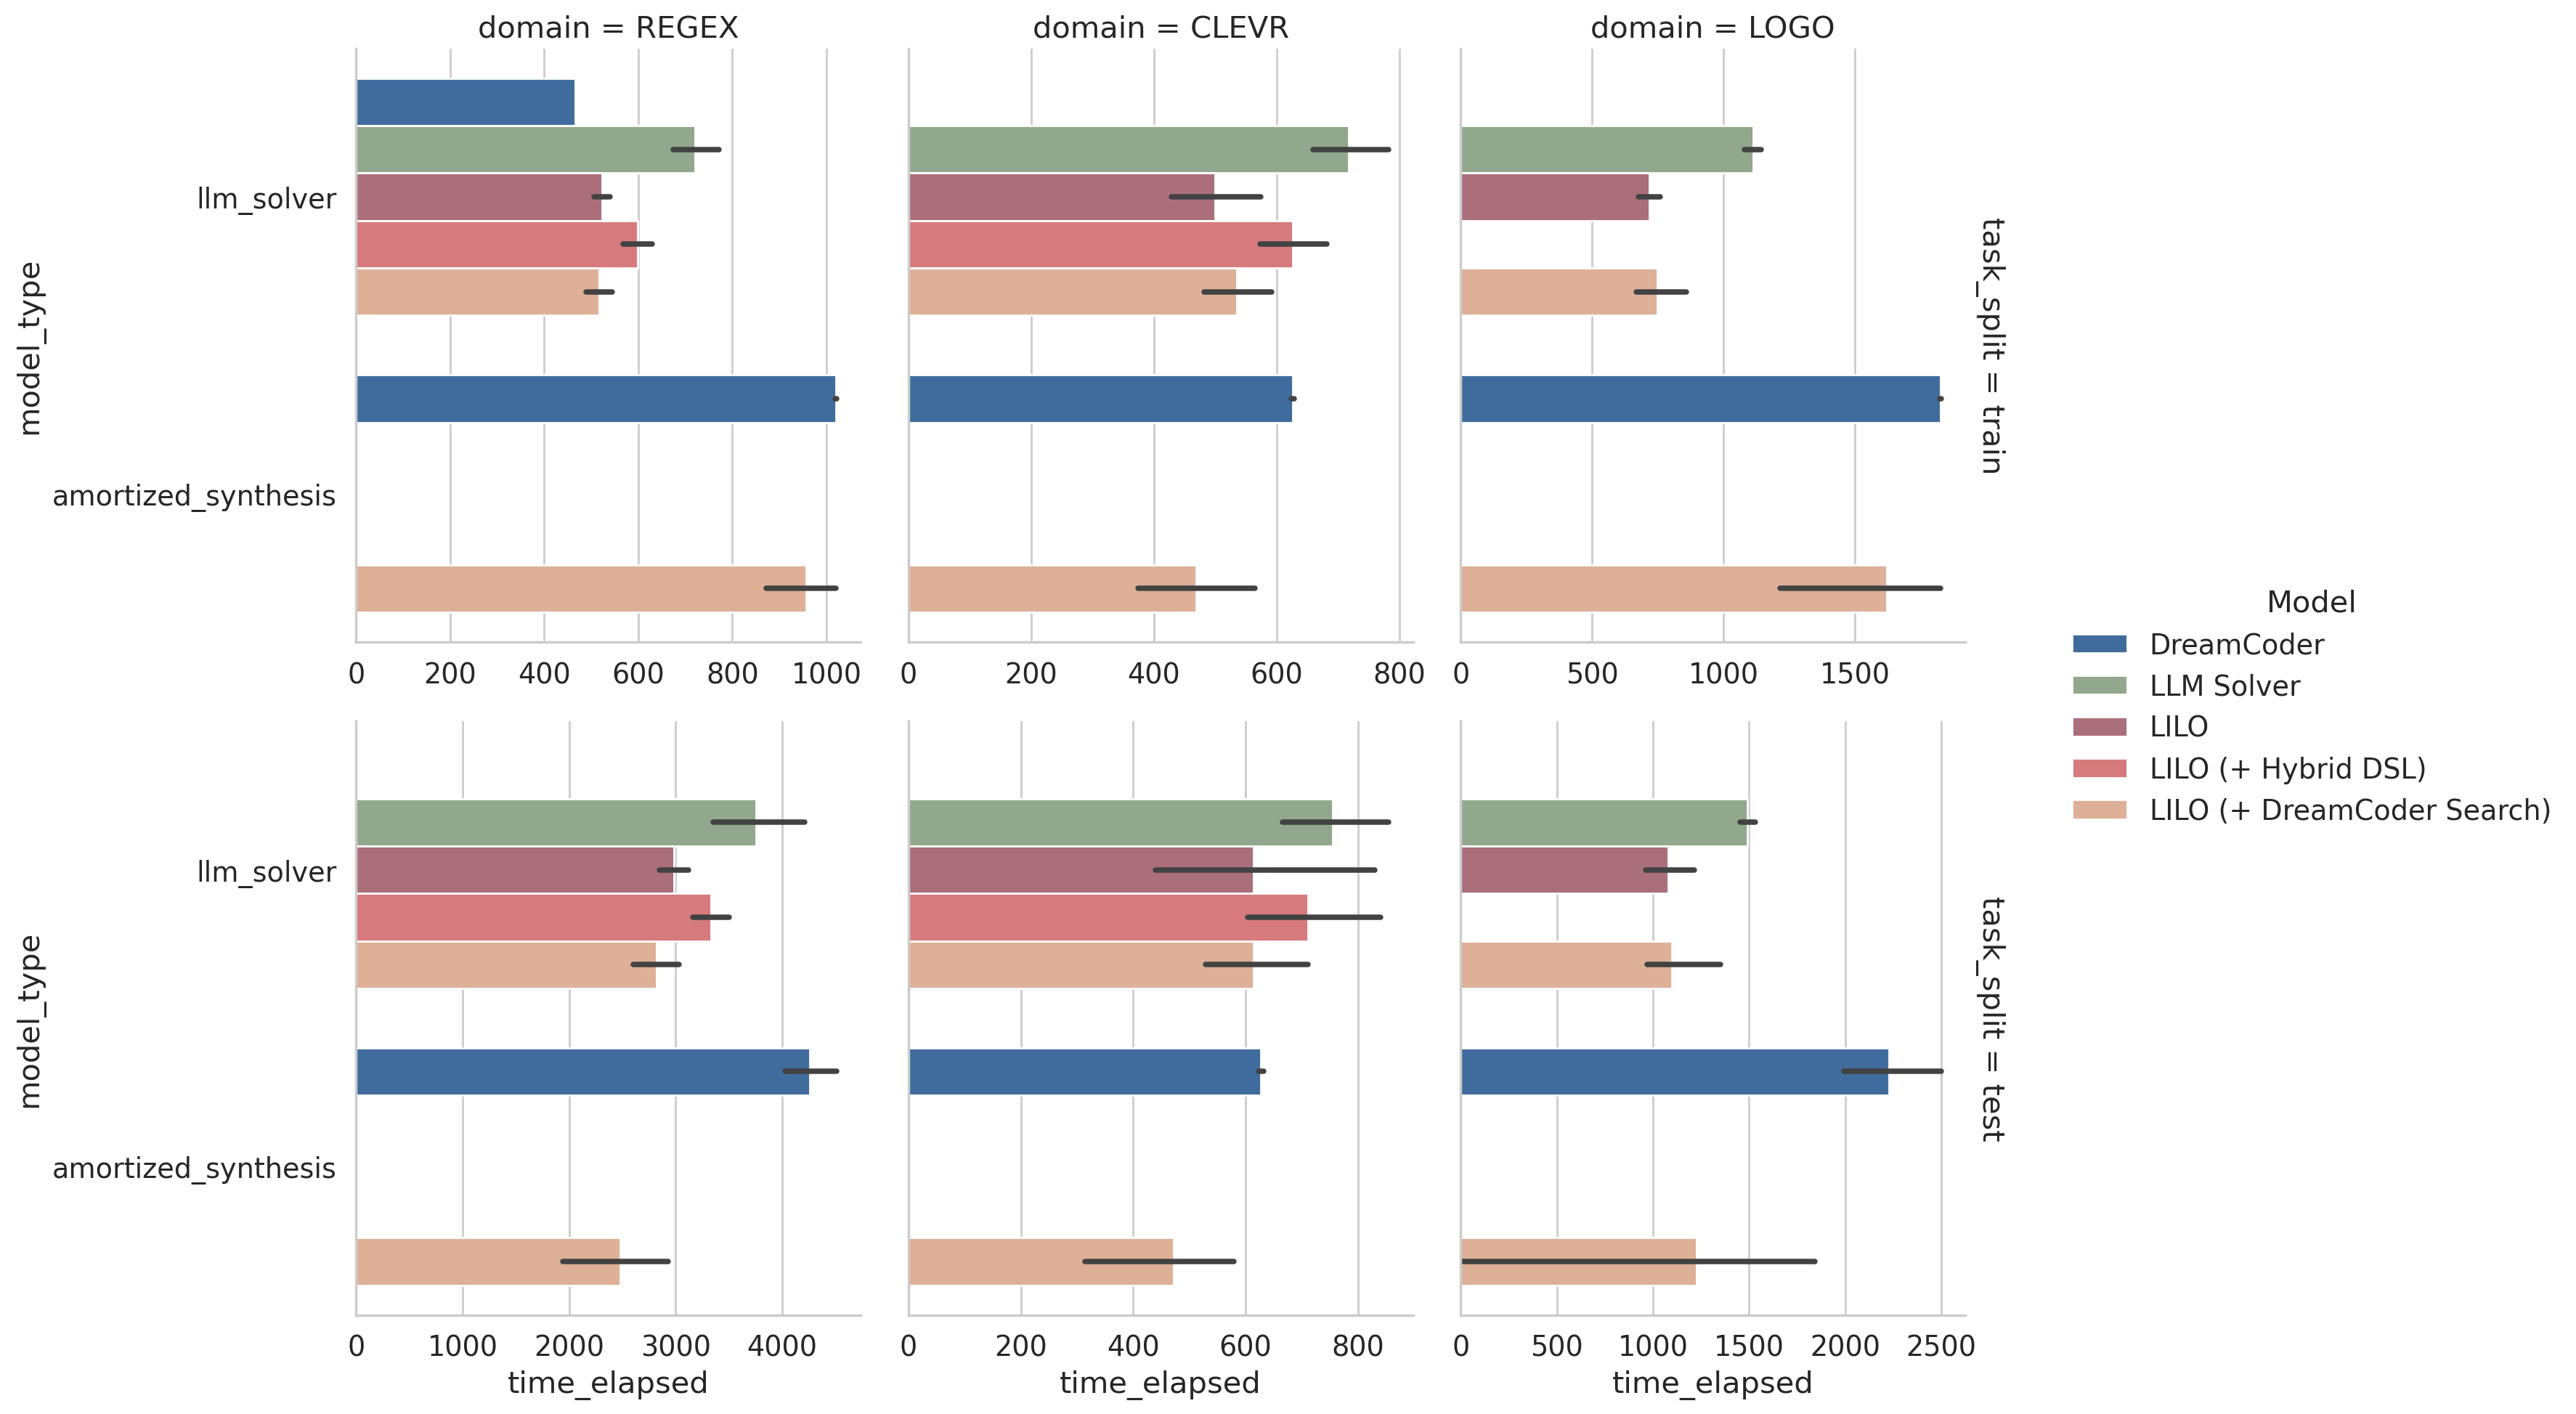

In [125]:
sns.catplot(
    data=analyzer.format_dataframe_camera(df_infer_programs), 
    kind="bar",
    col="domain",
    row="task_split",
    sharex=False, 
    y="model_type",
    x="time_elapsed", 
    hue=analyzer.COL_NAMES_CAMERA["experiment_type"],
    palette=analyzer.EXPERIMENT_TYPES_PALETTE,
    margin_titles=True,
)

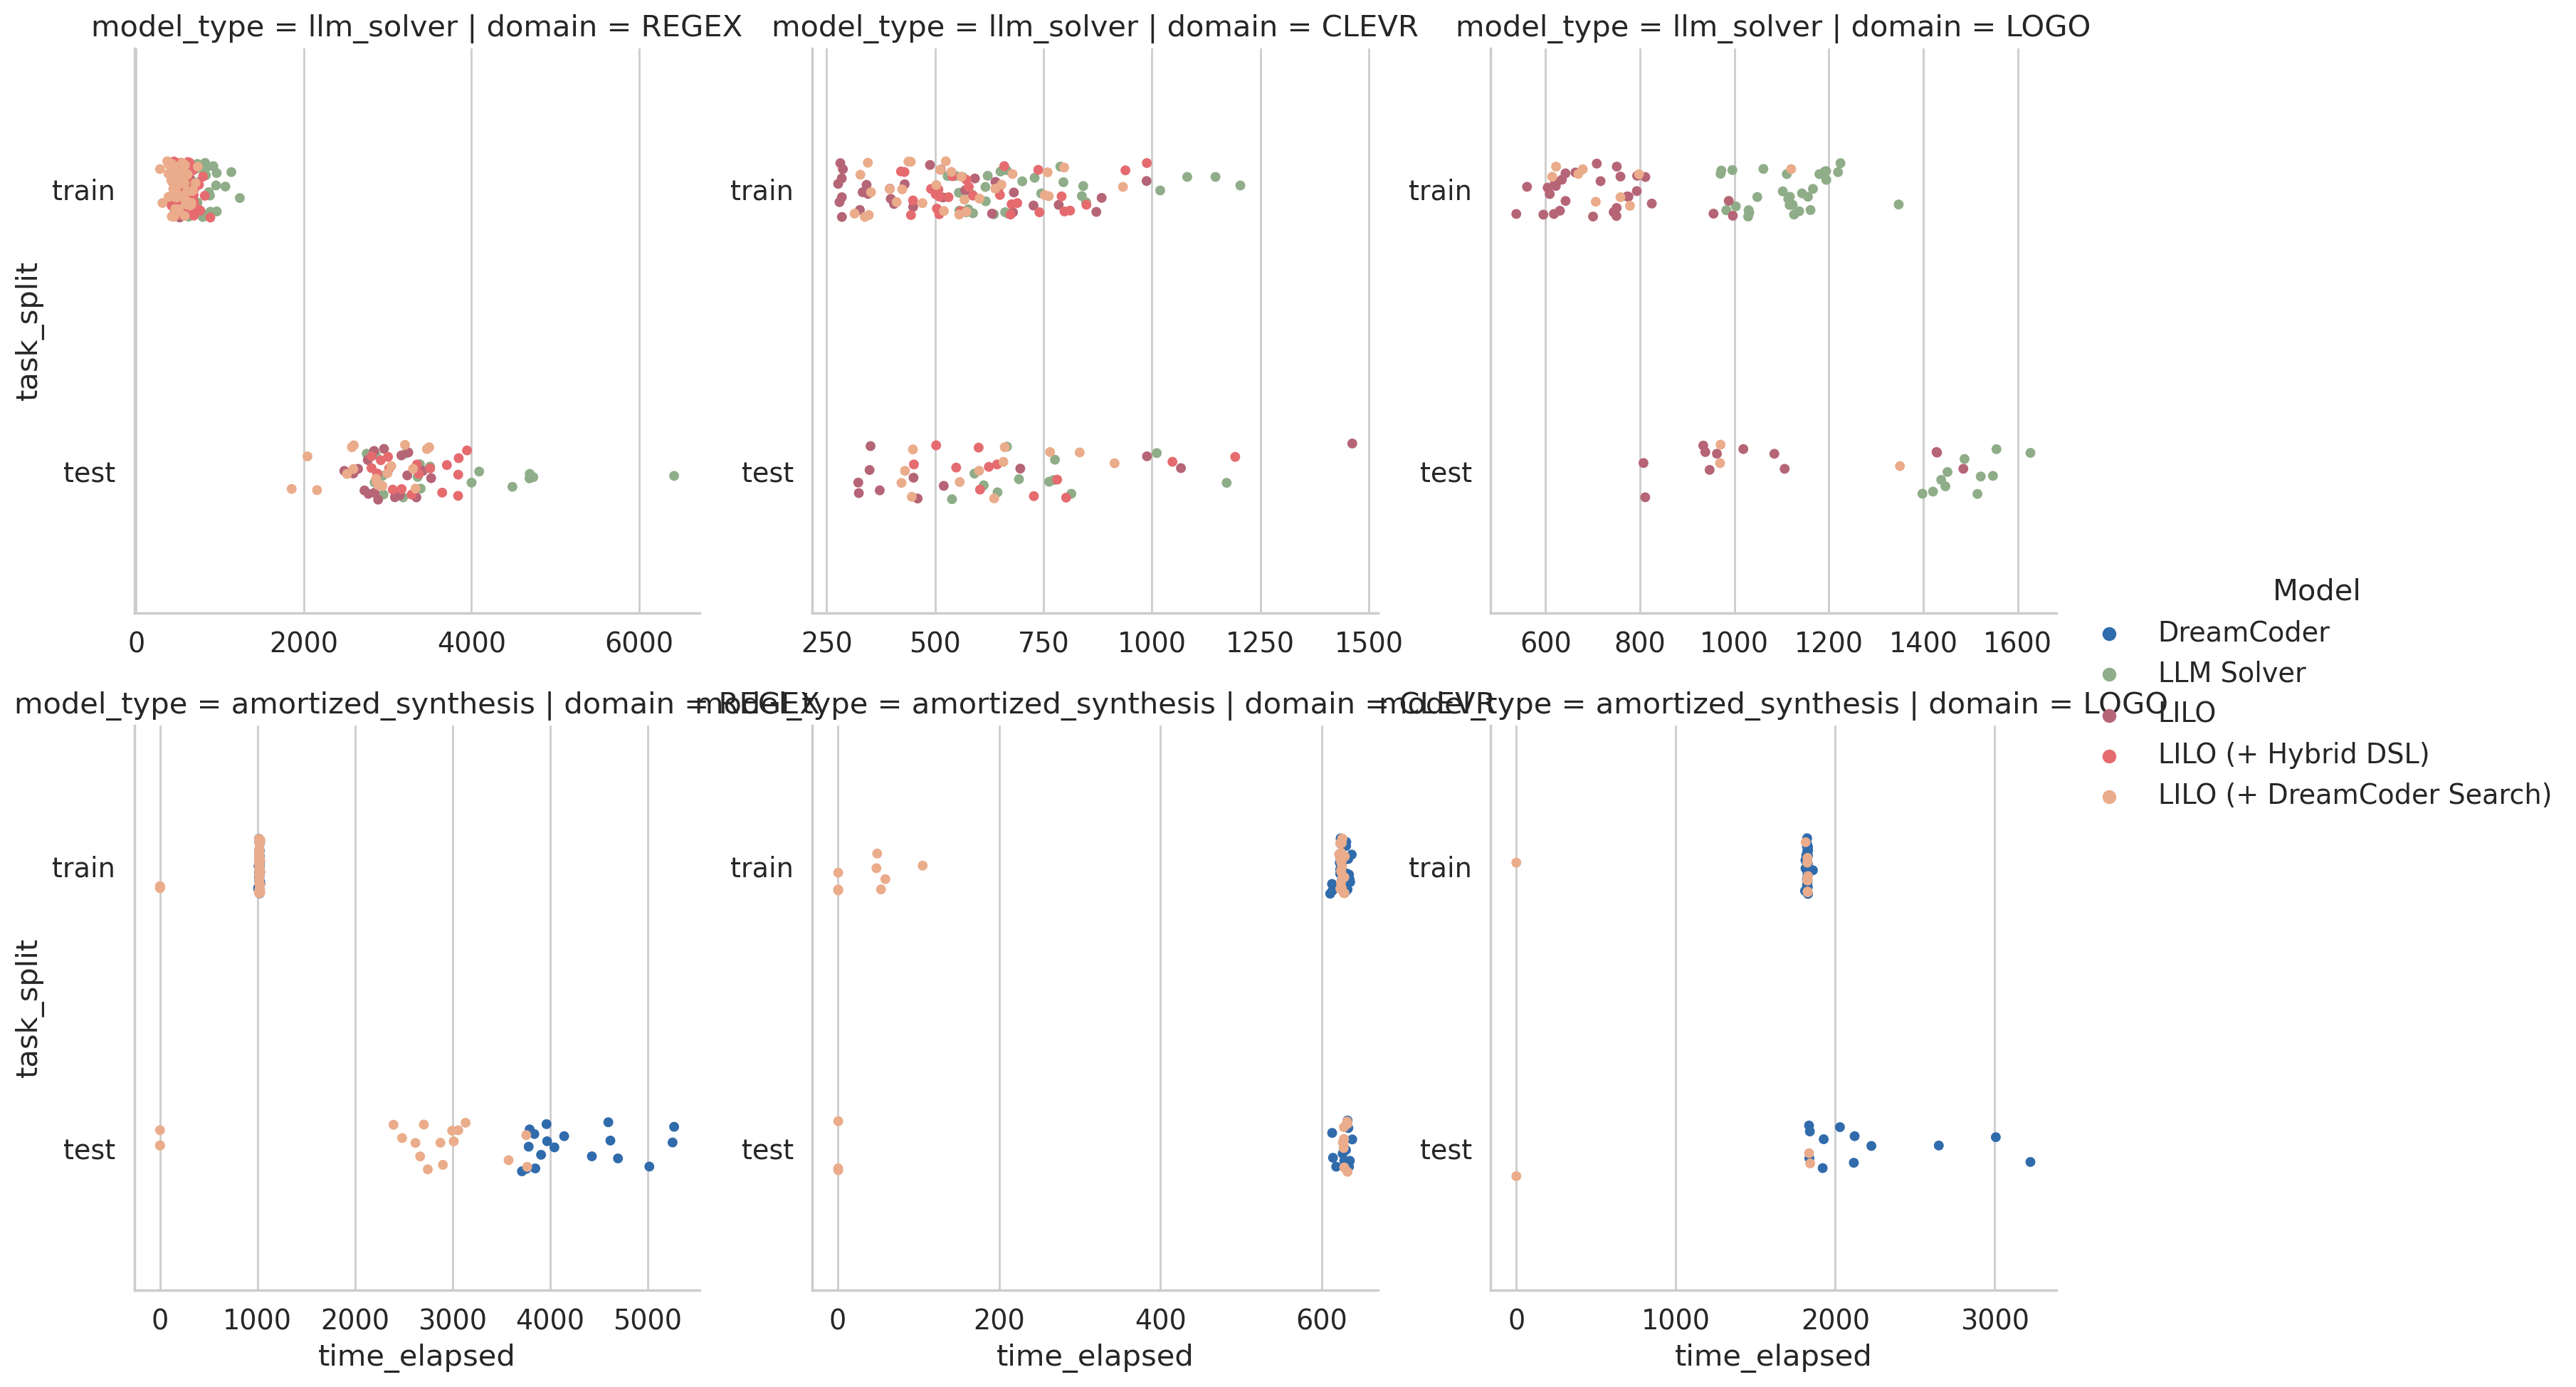

In [126]:
sns.catplot(
    data=analyzer.format_dataframe_camera(df_infer_programs), 
    kind="strip",
    col="domain",
    row="model_type",
    sharex=False, 
    sharey=False,
    y="task_split",
    x="time_elapsed", 
    hue=analyzer.COL_NAMES_CAMERA["experiment_type"],
    palette=analyzer.EXPERIMENT_TYPES_PALETTE,
    margin_titles=True,
)

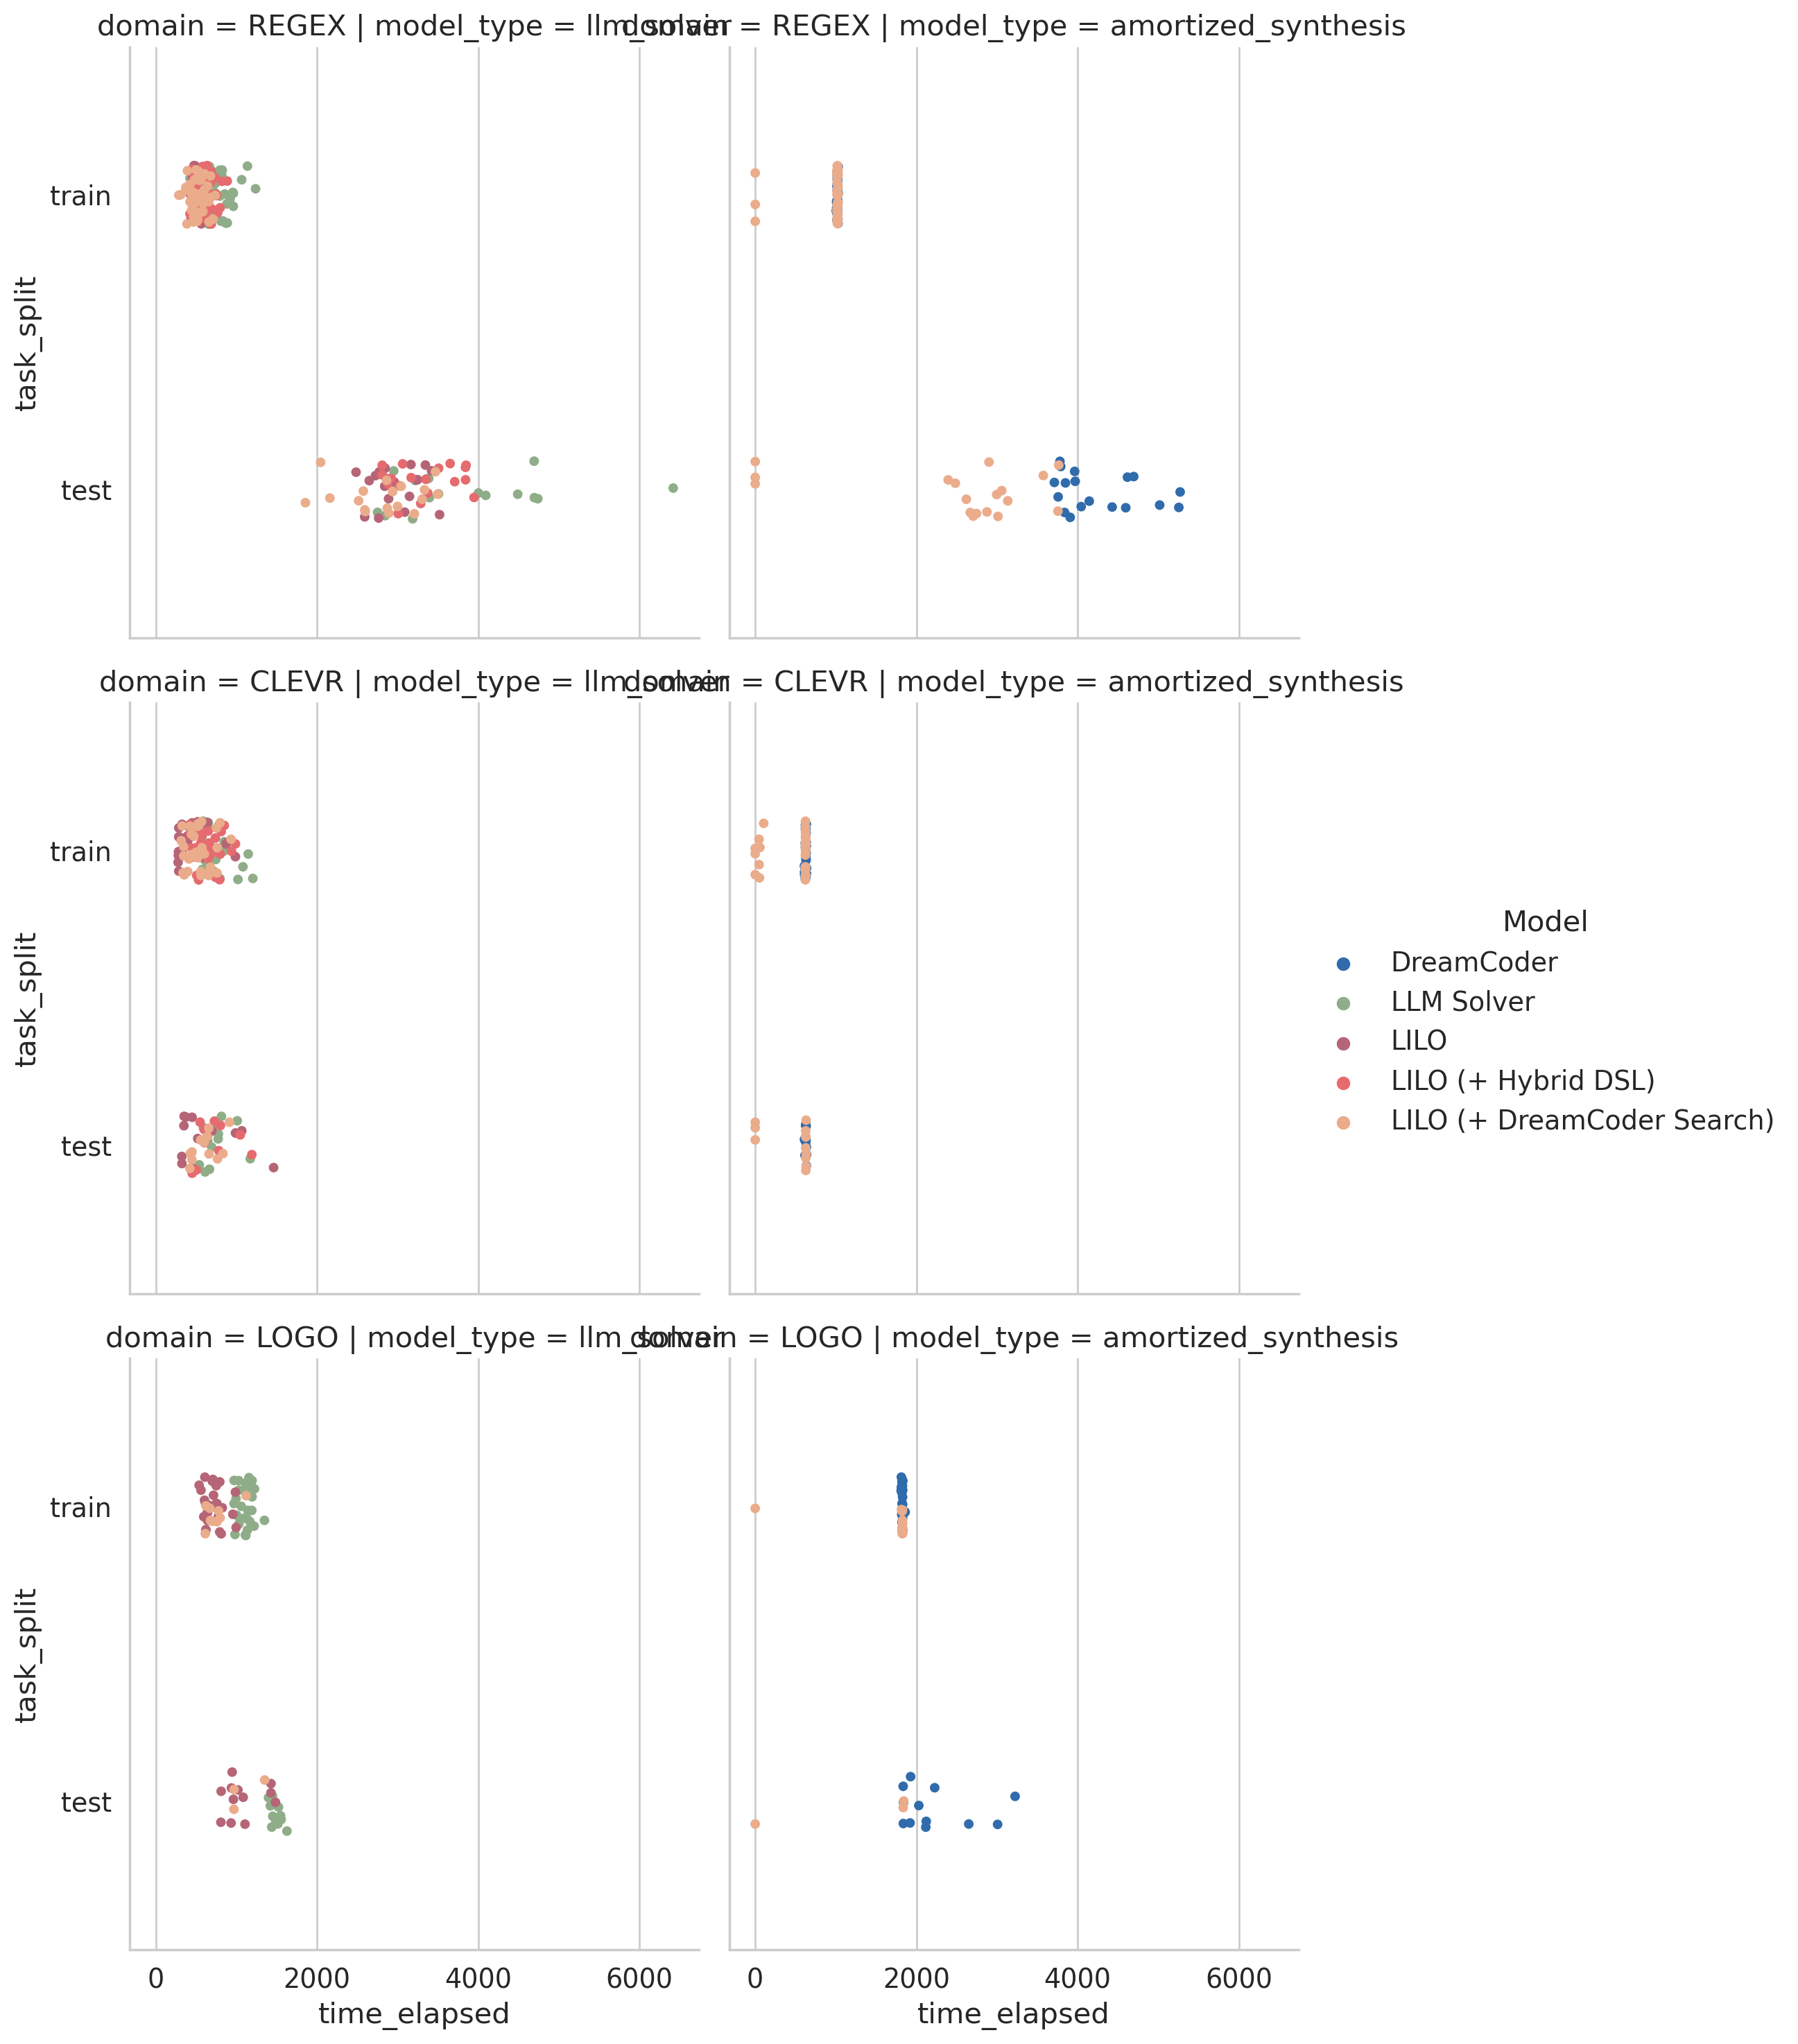

In [127]:
sns.catplot(
    data=analyzer.format_dataframe_camera(df_infer_programs), 
    kind="strip",
    col="model_type",
    row="domain",
    sharex=True,
    # sharey=False,
    y="task_split",
    x="time_elapsed", 
    hue=analyzer.COL_NAMES_CAMERA["experiment_type"],
    palette=analyzer.EXPERIMENT_TYPES_PALETTE,
    margin_titles=True,
)